# Inference optimizations

## Goal

During inference, how do you run a model in an optimized way ? Higher speed, faster throughput, given that you have already trained the model ?

## Overview

4 methods

1) Quantization
2) Pruning
3) Distillation
4) Other engineering optimizations

Each have their pros and cons

Let's first look at the pros and cons, and the tradeoffs between these 4 methods before we dive deep into each of them

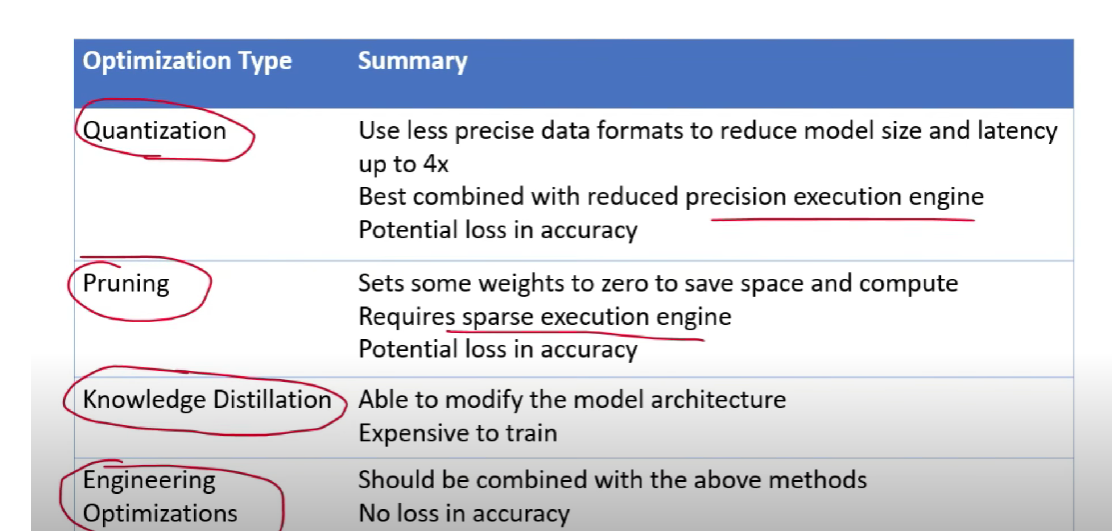


All these techniques have a tradeoff

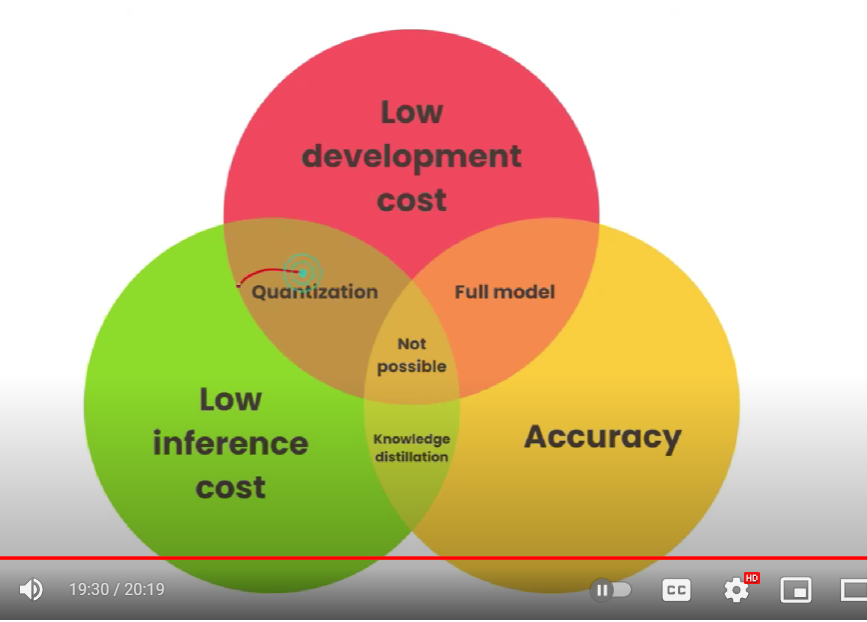

Ok, let's deep dive into each approch now

## Quantization

The goal is to convert parameters of the model from FP32 (usual standard during training) to a lower resolution such as FP16 or INT8 to be used during inference

(Note : There are training variants which use lower precision such as mixed precision, etc, that is out of scope of this article, this just deals with optimization of inference)

FP32 uses 32 bits to store each floating point number (hence the name !)

FP16 uses 16 bits to store each floating point number, so it reduces model memory by half

INT8 uses 8 bits to store each integer number, so it reduces model memory by 75% compared to FP32

Here is the same weight vector represented in these 3 formats

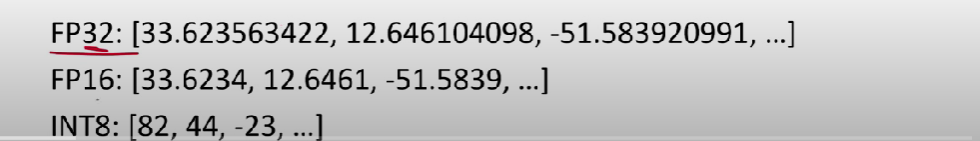

Note : INT8 means there are 2 ** 8 possible values = 256, therefore all values should be between 0 and 255, or alternatively if you want a symmetric represetation -128 to +127



### How do you convert a FP32 to INT8 ?

Several techniques, one common technique is 0-point quantization

Here, 
1) 0 in FP32 remains as 0 in INT8
2) We take the max absolute value across all the parameters in the model, and mark that as +127 or -128 depending on whether the max value was neg or +ve
3) Now we have two mappings : 0 -> 0, max abs value -> -128, for example, you can use a simple linear transformation scale to map all other values to the range -128 to 127

Here's an example



If you want to convert to 0 to 255 scale, add 128 to every number thus obtained

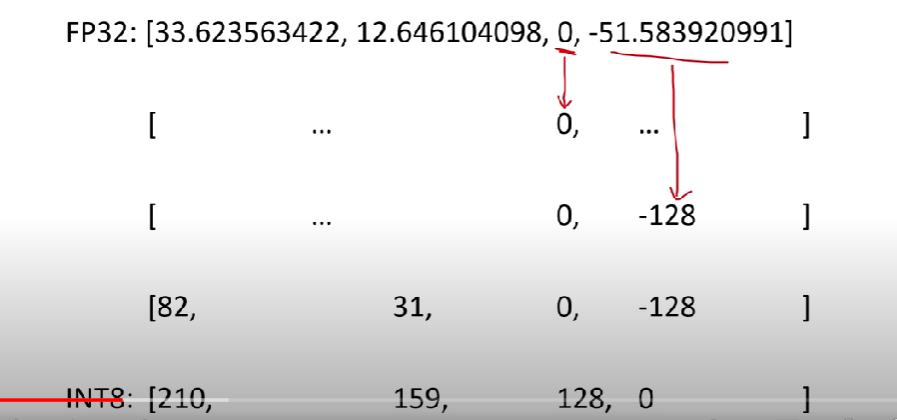



### Which parameters do you convert ?

Which parameters do you convert from FP32 to INT8 ?

You can either convert weights , or activations

Method 1 : Weight quantization
1) Store weights in INT8, dequantize into FP32 while running
2) This just saves memory, and not compute, as all computations still happen in FP32

Method 2 : Activation quantization
1) Weights are in in INT8, all inputs and outputs are converted to INT8
2) Therefore impact on both memory and compute
3) Faster than weight quantization, but needs calibration (to determine scale factors for data at every layer)





What is calibration ? We are in effect doing a scale transformation - transforming [a,b] seen in FP32 to [-128,127] or [0,255] in INT8

We need to know a and b in the original FP32 space to calibrate well

For weight calibration, this is easy, because we know all the weights during training, we can just take the max of it (Which is what the zero point calibration technique above did), and the same weights will be used during inference

For activation calibration, if the input data is even slightly different at inference time compared to training time, you can get activation values which you never saw in training, and this can result in clipping, so the network can fail (for example, if you saw an activation value much larger during inference than train time, and you have a naive calibration strategy, the activation value will be clipped to max and min values, not the real values)

There are different approaches for this

1) Post training dynamic quantization: - the range for each activation is computed on the fly at runtime. This is very nice in theory, challenges are not all hardware support this, and a bit slower than static quantization because you need to keep recomputing the range [a,b]

2) Post training static quantization - the range for each activation is computed in advance at quantization-time, typically by passing representative data through the model and recording the activation values. 

The steps are
a) Observers are put on activations to record their values.
b) A certain number of forward passes on a calibration dataset is done (around 200 examples is enough).
c) The ranges for each computation are computed according to some calibration technique.

One clear disadvantage here, what do you do if you see something in inference which was not captured in your representative data, and gives an activation outside the range you would want ?

3) Quantization aware training
Range for each activation is computed at training-time, broad idea similar to 2) except we compute ranges at training time itself instead of with separate representative data after training. One difference : “fake quantize” operators are used instead of observers: they record values just as observers do, but they also simulate the error induced by quantization to let the model adapt to it




https://huggingface.co/docs/optimum/concept_guides/quantization

Calibration options are simple min-max to get [a,b]; moving average min-max to get [a,b]; more complex approaches

HF has these practical steps to choose 

Pratical steps to follow to quantize a model to int8
To effectively quantize a model to int8, the steps to follow are:

1) Choose which operators to quantize. Good operators to quantize are the one dominating it terms of computation time, for instance linear projections and matrix multiplications.
2) Try post-training dynamic quantization, if it is fast enough stop here, otherwise continue to step 3.
3) Try post-training static quantization which can be faster than dynamic quantization but often with a drop in terms of accuracy. Apply observers to your models in places where you want to quantize.
4) Choose a calibration technique and perform it.
5) Convert the model to its quantized form: the observers are removed and the float32 operators are converted to their int8 coutnerparts.
6) Evaluate the quantized model: is the accuracy good enough? If yes, stop here, otherwise start again at step 3 but with quantization aware training this time.



How much quantization benefits also depends on the GPU , some GPUs will not see a significant benefit from quantization 

Look at the GPU specification

For NVIDIA A10, for example, this is the specification

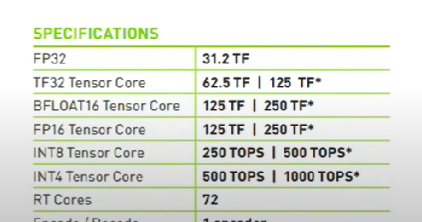

the FP32 performance is 31.2 TerraFlops, the INT8 performance is  250 TF (about 8X faster)



### Disadvantage

The primary disadvantage is loss of accuracy

One paper LLM.int8 (https://openreview.net/pdf?id=dXiGWqBoxaD)  found that in Large language models , at sizes greater than a certain value, using quantization drives model accuracy to 0 !!

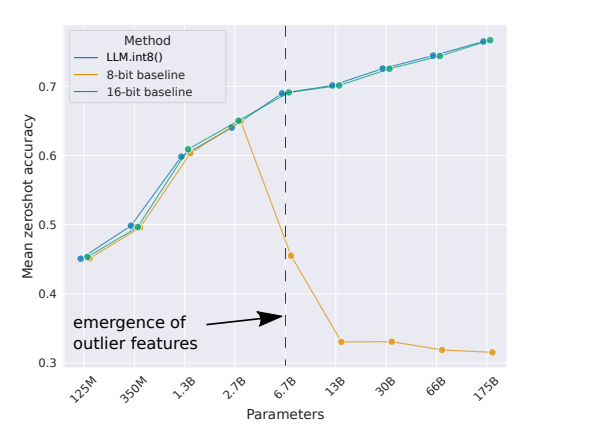

They propose an alternate strategy called LLM.int8 (TODO : READ UP ON THIS) to handle quantization for these larger models without loss in accuracy. Use mixed decomposition to handle outliers separately

https://huggingface.co/blog/hf-bitsandbytes-integration

## Pruning

During inference, remove some of the connections of NN (similar to dropout ) to get a sparse matrix

Many algorithms exist

One simple algorithm is magnitude pruning

1) Fix a pruning factor X
2) In each layer X, set X% of the weights (by absolute value ) to 0. (Why ? The expectation is lower absolute value weights contribute lesser)
3) Optionally, if you think performance is degrading a lot, retrain the model for a few more epochs keeping these weights to 0

Note

Setting some of the weights to 0 doesn't automatically mean better performance, as 0 takes just as much space to store and time to process with non-zero values

We need to combine pruning with a sparse execution engine which can do special matrix computations on sparse matrixes

(sparse matmul)


### Structured pruning

What we discussed earlier is unstructured pruning (setting random positions in weight matrix to 0 based on abs. value, for example)

Structured pruning is where in the matrix you want to sparsify, you set certain combinations of adjoint cells to 0, to enable better matrix multiplication decomposition


For example, N:M sparsity is a structured pruning technique

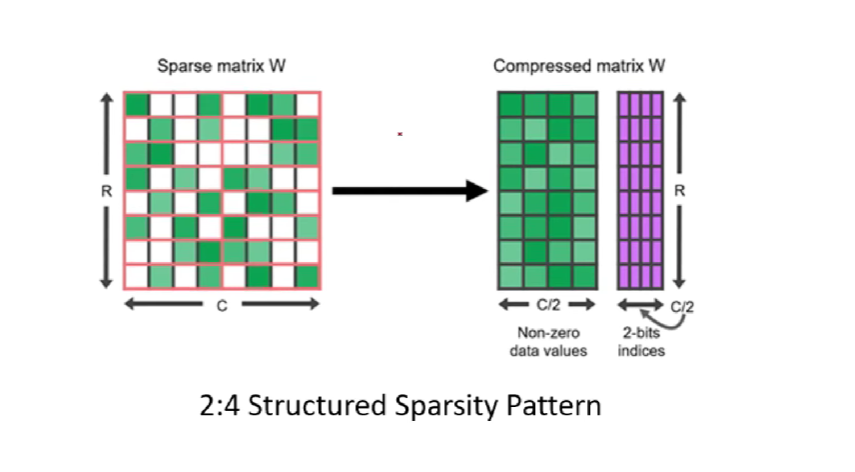

Ina 2:4 setting, in each block of 4 consecutive matrix weights, only 2 allowed to be non-zero

This allows clever matrix decomposition




The pruning algorithm choice has a dependency on hardware, For example, tensor core from NVIDIA supports 2:4 pruning

## Knowledge Distillation

Have a teacher network which is a big model which is trained. Train a student (much smaller network) on the output of the teacher network

This is the basic 2-step version

Why does this work ? Why can't you train the student network directly on the GT labels, instead of a circuitous property of training the teacher network on the GT labels, and student network on the output ?

Because the predicted probabilities from teacher network as GT is richer
For example, if its a 10 class problem, the GT labels has one 1 and 9 0's, whereas the teacher network gives 10 probabilities which is richer

This method is called response-based distillation, as its trained on the response of the teacher network. This is the most common type of distillation


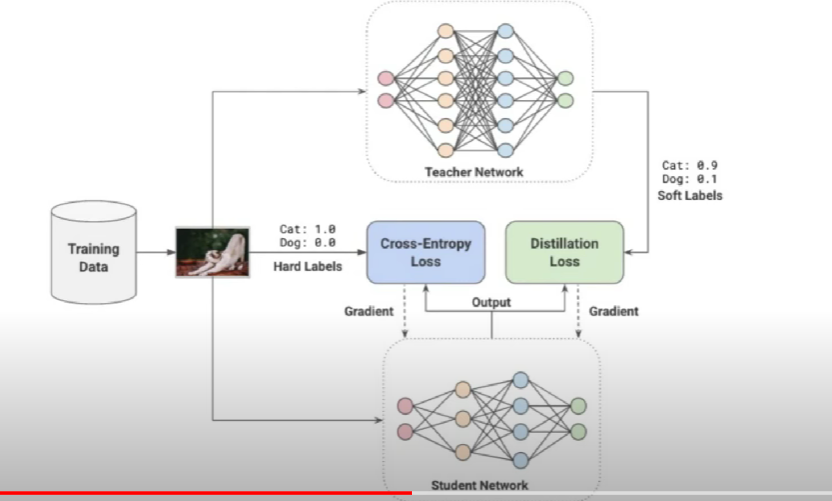

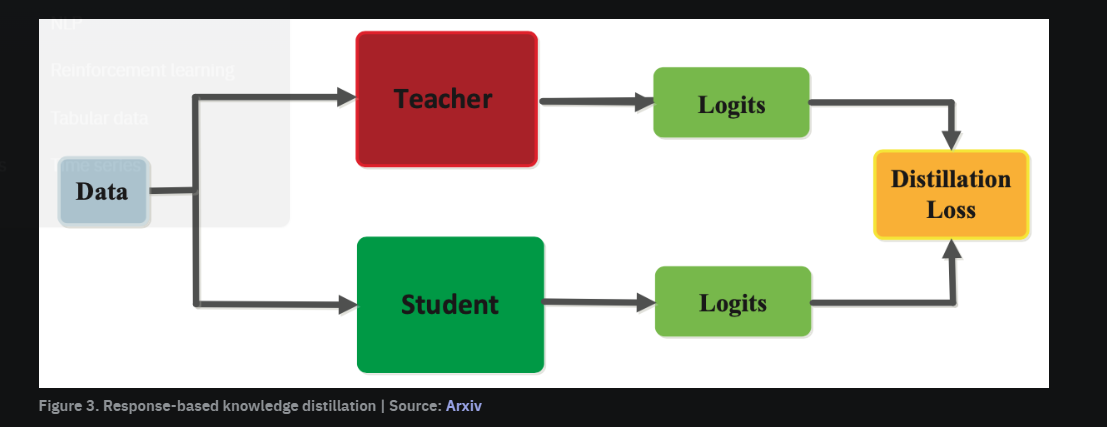


https://intellabs.github.io/distiller/knowledge_distillation.html#:~:text=where%20T%20is%20the%20temperature,similar%20to%20the%20predicted%20class.

There are two nuances here

1) We don't use the probabilities predicted by the teacher network as GT directly, instead we use a softmax of the logits at a temperature > 1, to make the teacher network probabilities more spread out, to help the student learn more

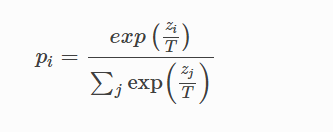

The same temperature value set to the teacher network, is used in the student network too during training

2) During training the smaller model we use a weighted combination of the loss against the teacher model prediction , and the actual GT (the standard loss, called the student loss here)

For the student loss, a temperature of 1 is used

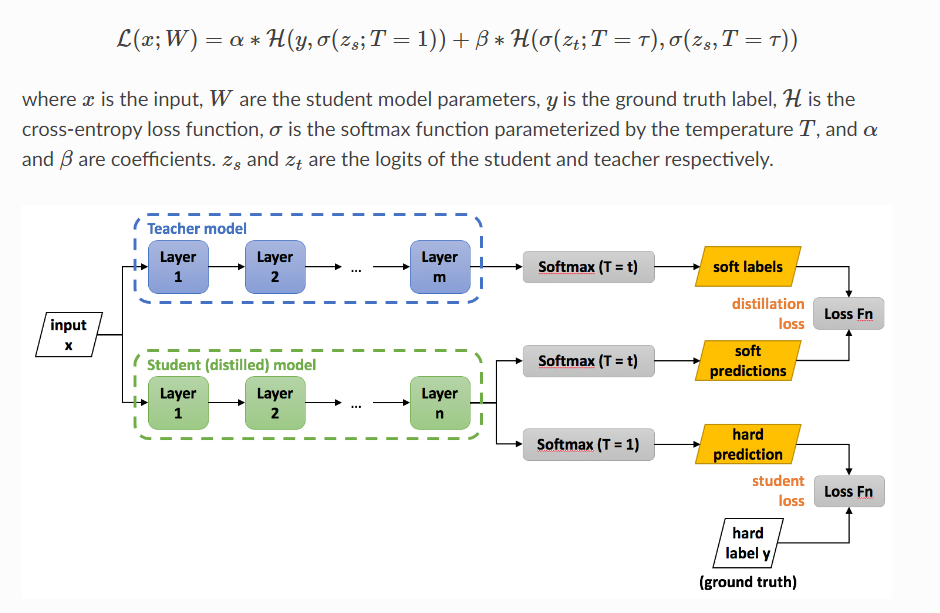

https://neptune.ai/blog/knowledge-distillation

Alternatives of response based Knowledge distillation

2) Feature-based

The goal is to train the student model to learn the same feature activations as the teacher model. The distillation loss function achieves this by minimizing the difference between the feature activations of the teacher and the student models

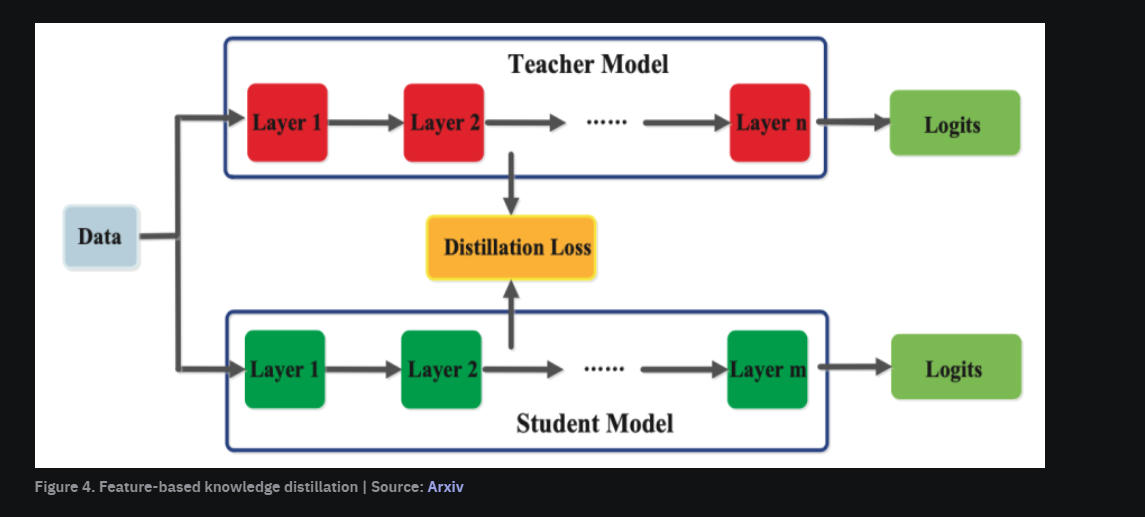


3) Relation-based knowledge

Knowledge that captures the relationship between feature maps can also be used to train a student model. 

This relationship can be modeled as correlation between feature maps, graphs, similarity matrix, feature embeddings, or probabilistic distributions based on feature representations. 

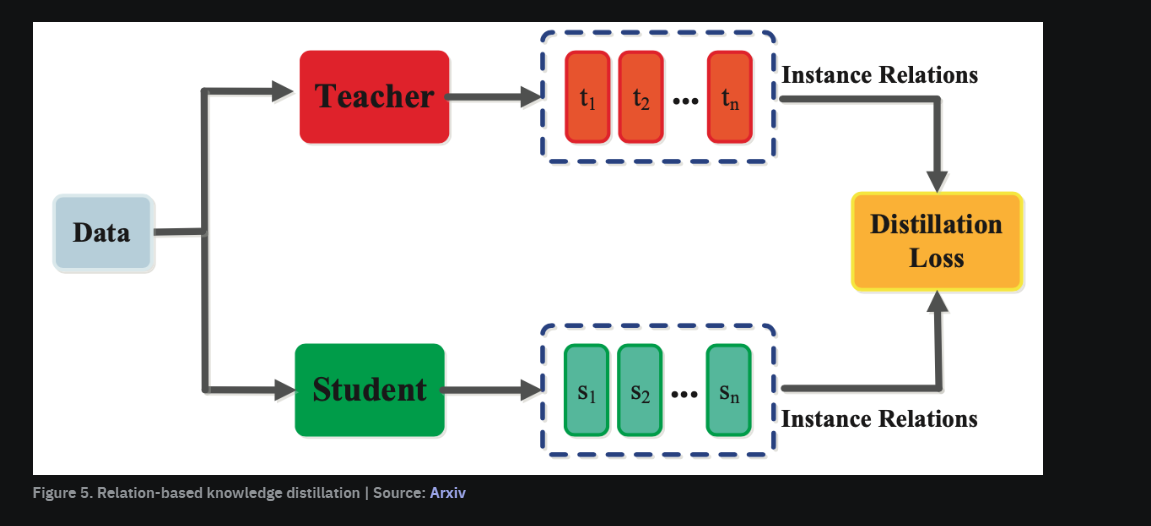

### Advantages and Disadvantages

Advantage

1) Flexibility in deciding architecture of student network (not possible in quantization and pruning)

Disadvantage

1) Expensive - Takes 5-10% of total GPU hours taken to train the original teacher model

## Engineering optimizations

1) Run your model on CPU or GPU during inference needs efficiently needs better integration between hardware and software

Example : Vectorized operations to handle matrix computations on GPU is great, but even on CPU, with certain software drivers (AVX-512)

2) Techniques like flash attention - which fuses together attention operations, and does GPU tiling and optimization acc to GPU's memory heirarchy to be more efficient

https://huggingface.co/docs/text-generation-inference/conceptual/flash_attention

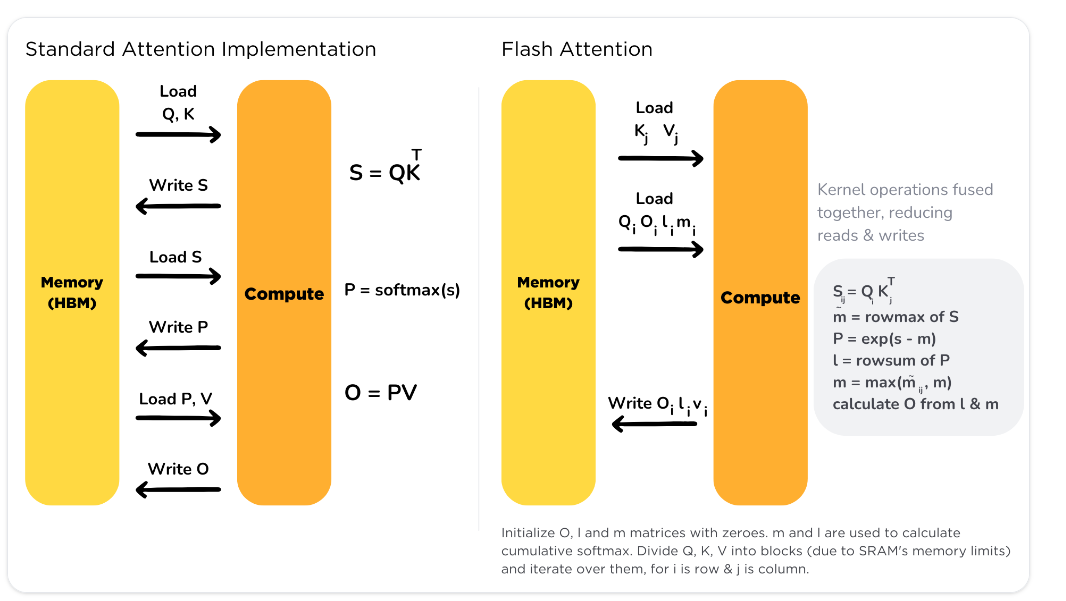

Flash attention minimizes io steps of moving data from HBM (High bandwidth memory) to the SRAM on GPU repeatedly during one attention call

 In the standard attention implementation, the cost of loading and writing keys, queries, and values from HBM is high. It loads keys, queries, and values from HBM to GPU on-chip SRAM, performs a single step of the attention mechanism, writes it back to HBM, and repeats this for every single attention step. Instead, Flash Attention loads keys, queries, and values once, fuses the operations of the attention mechanism, and writes them back.
 


To enable these optimizations, formats such as storing models as ONNX (and having ONNX runtime for inference) or tflite

ONNX (Open Neural Network Exchange) https://towardsdatascience.com/onnx-the-standard-for-interoperable-deep-learning-models-a47dfbdf9a09 is aan open source standard for representing deep learning models

One of the main advantages of ONNX is that it allows models to be easily exported from one framework, such as PyTorch, and imported into another framework, such as TensorFlow

The other advantage is ONNX runtime - ONNX also provides a set of tools for optimizing and quantizing models, which can help to reduce the memory and computational requirements of the model. This can be especially useful for deploying models on edge devices and other resource-constrained environments.

### ONNX Runtime

ONNX Runtime is an open-source inference engine for executing ONNX (Open Neural Network Exchange) models. It is designed to be high-performance and lightweight, making it well-suited for deployment on a wide range of hardware platforms, including edge devices, servers, and cloud services.

It abstracts out CPU-GPU , torch-tensorflow, and everything else

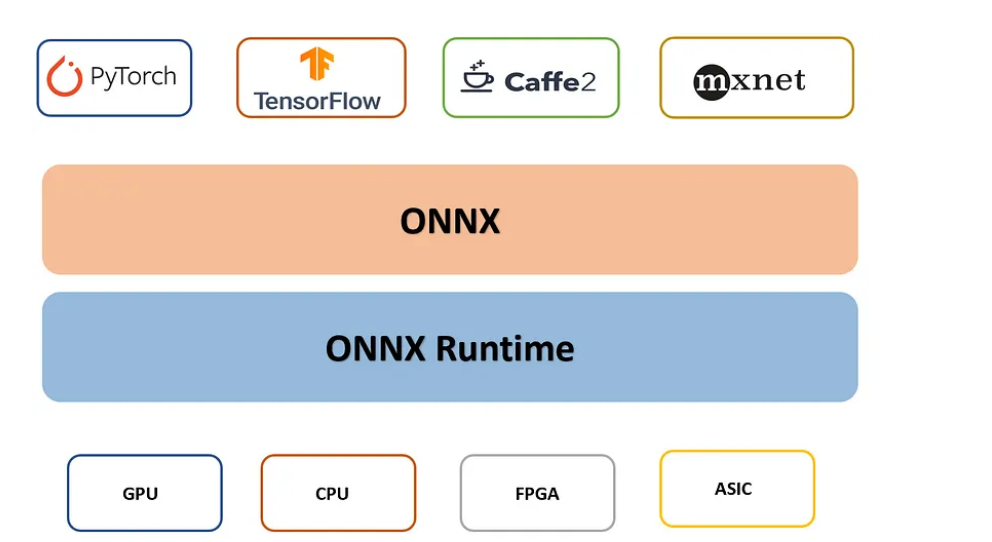


It uses various techniques such as Just-In-Time (JIT) compilation, kernel fusion and subgraph partitioning to optimize the performance of the model. It also supports thread pooling and inter-node communication for distributed deployment which makes it a suitable choice for large-scale deployment.

ONNX Runtime also provides support for a wide range of models, including both traditional machine learning models and deep learning models

## References

1) https://www.youtube.com/watch?v=UcwDgsMgTu4&t - Very nice video comparing and contrasting methods
2) https://huggingface.co/docs/optimum/concept_guides/quantization - Guide on quantization
3) Deepdive into quantization -  https://leimao.github.io/article/Neural-Networks-Quantization/
4) https://openreview.net/pdf?id=dXiGWqBoxaD - effect of improper quantization driving model performance to 0
5) https://medium.com/@yanis.chaigneau/pruning-in-neural-networks-541af4f9a899#:~:text=As%20we%20saw%20in%20the,connections%20between%20neurons%20were%20suppressed. - Nice article on pruning
6) https://neptune.ai/blog/knowledge-distillation - Nice article on knowledge distillation
7) https://intellabs.github.io/distiller/knowledge_distillation.html#:~:text=where%20T%20is%20the%20temperature,similar%20to%20the%20predicted%20class.
8) https://huggingface.co/docs/text-generation-inference/conceptual/flash_attention - flash attention
9) https://towardsdatascience.com/onnx-the-standard-for-interoperable-deep-learning-models-a47dfbdf9a09 - article on ONNX
10) https://lilianweng.github.io/posts/2023-01-10-inference-optimization/ - As always , Lilian weng's blog is great
